# Predicting the valence and arousal of arbitrary words with scikit-learn
<b> CS613 Natural Language Processing IIT Gandhinagar <br>
    Online Content by <br>
    Sohhom Bandyopadhyay (15510011) <br>
    November 2018 <br>
</b>


## Background and Theory

Dimensional theory of emotion says ... 

### Basic goal

Word2Vec and other word embeddings provide a representation of words in a ${\Bbb R^n}$ space, whereas the dimensional emotion ratings of the word can be taken to be another representation in ${\Bbb R^3}$ space (when emotions are assumed to have three independent dimensions).

### Dataset
ANEW (Affective Norms for English Words) is a dataset of words, that "... have been rated in terms of pleasure, arousal, and dominance in order to create a standard for use in studies of emotion and attention" [1]. It was first published in 1999 [2], and the 2017 version includes over 3000 words. <br>
It provides ratings for each word in terms of pleasure, arousal, and dominance, where:
- Pleasure ("affective valence") ranges from "pleasant to unpleasant" 
- Arousal ranges from "calm to excited"
- Dominance ranges from "controlled to in-control"

Each dimension is coded from 1 (low) to 9 (high).


The code and outputs below demonstrate how the above goal can be achieved using this dataset, on a sample paragraph taken from a news article.

In [23]:
import pandas as pd
import gensim
from sklearn.linear_model import LinearRegression
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib

In [34]:
df = pd.read_csv('anew2017_data.csv', usecols = [0,2,3,4,5,6,7])
rating_matrix = df.iloc[:,[0,1,3,5]].set_index('word').T.to_dict(orient='list')
df.head(10)

,word,valence,valence_sd,arousal,arousal_sd,dominance,dominance_sd
0,abandon,2.36,1.65,4.66,2.61,3.45,2.44
1,abduction,2.76,2.06,5.53,2.43,3.49,2.38
2,able,6.74,2.00,4.30,2.17,6.83,2.04
3,abortion,3.50,2.30,5.39,2.80,4.59,2.54
4,abrupt,4.22,1.50,4.95,2.16,4.78,1.88
5,absent,3.69,1.72,4.73,1.76,4.35,1.87
6,absurd,4.26,1.82,4.36,2.20,4.73,1.72
7,abundance,6.59,2.01,5.51,2.63,5.80,2.16
8,abundant,6.77,1.74,5.22,2.36,5.70,1.77
9,abuse,1.80,1.23,6.83,2.70,3.69,2.94


In [33]:
for var in df.columns[1:]:
    print (df[var].min(), df[var].max(),var)

1.25 8.82 valence
0.31 3.31 valence_sd
2.29 8.17 arousal
1.1 3.38 arousal_sd
2.17 7.88 dominance
0.61 3.24 dominance_sd


In [42]:
# random text block, taken from
# https://www.scientificamerican.com/article/insect-metamorphosis-evolution/

text1 = """Imprisoning someone for asserting what today qualifies as common knowledge might seem extreme, 
but metamorphosis - the process through which some animals abruptly transform their bodies after birth - has long 
inspired misunderstanding and mysticism. People have known since at least the time of ancient Egypt that worms 
and grubs develop into adult insects, but the evolution of insect metamorphosis remains a genuine biological 
mystery even today. Some scientists have proposed outlandish origin tales, such as Donald Williamson's idea that 
butterfly metamorphosis resulted from an ancient and accidental mating between two different species—one that 
wriggled along ground and one that flitted through the air.""".lower()


# basic preprocessing to help match words
# remove punctuation, convert to lowercase
translator = str.maketrans('', '', string.punctuation+'\n')
text_words = list(filter(lambda x: len(x)>1, text1.translate(translator).split(' ')))

In [15]:
wv_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True, limit=999900)

In [16]:
wvec_words = set(wv_model.vocab.keys())
senti_words = set(rating_matrix.keys())
common_words = wvec_words.intersection(senti_words)
len(common_words), len(wvec_words), len(senti_words)

(3181, 999900, 3188)

In [17]:
dataX = [wv_model[word] for word in common_words]
dataY = [rating_matrix[word] for word in common_words]
dataX = np.array(dataX)
dataY = np.array(dataY)
dataY.shape, dataX.shape

((3181, 3), (3181, 300))

In [18]:
regrModel= LinearRegression()
regrModel.fit(dataX,dataY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
ratings_anew = []
ratings_predicted = []

for tword in text_words:
    if tword in wvec_words:
        test_x = wv_model[tword].reshape(1,-1)

        pred_y = regrModel.predict(test_x)
        ratings_predicted.append(list(pred_y[0]))

        if tword in rating_matrix:
            ratings_anew.append(rating_matrix[tword])
        else:
            ratings_anew.append([-1,-1,-1])
            
ratings_anew = np.array(ratings_anew)
ratings_predicted = np.array(ratings_predicted)

In [20]:
matplotlib.rcParams['figure.figsize'] = 26,10

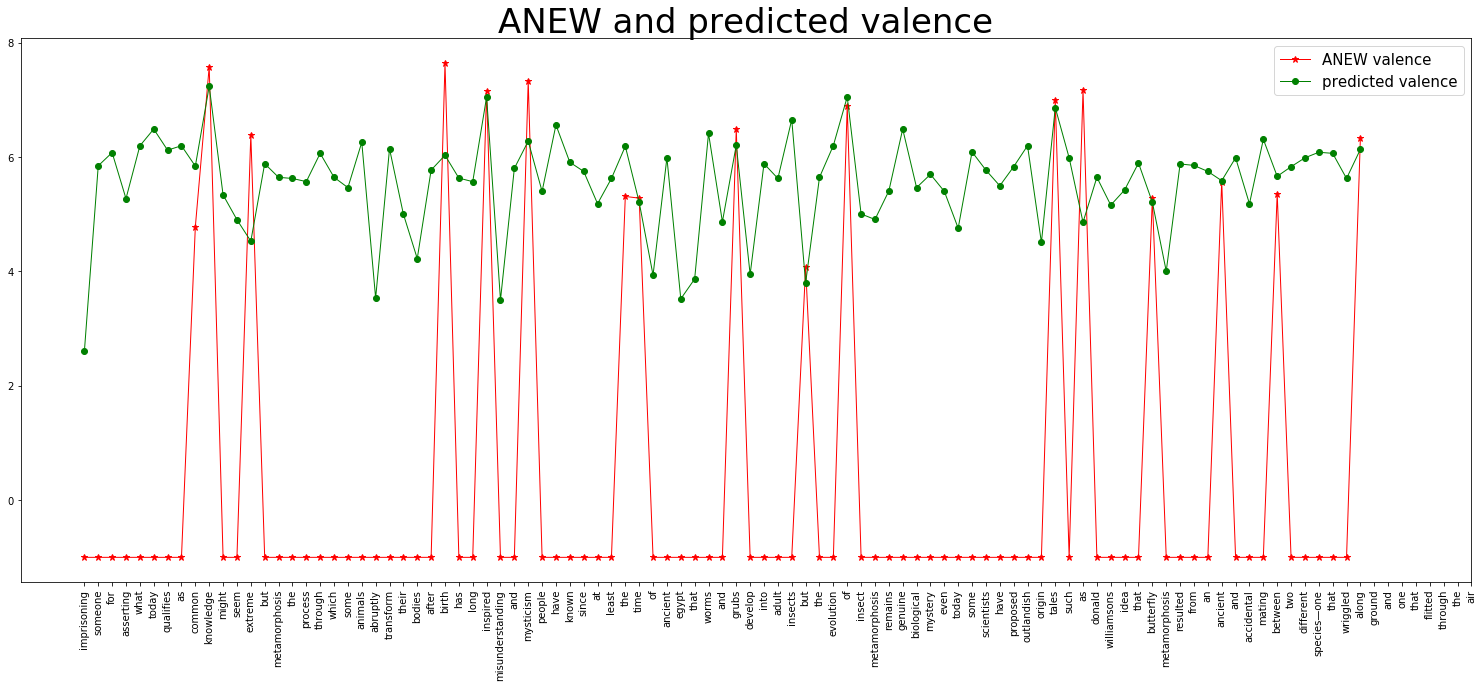

In [48]:
_, ax = plt.subplots()

ax.plot(ratings_anew[:,0], label='ANEW valence', lw=1, markersize = 7, marker = '*', color='red')
ax.plot(ratings_predicted[:,0], label='predicted valence', lw=1, markersize = 6, marker = 'o', color='green')

ax.set_xticklabels(text_words)
ax.xaxis.set_ticks(np.arange(0, len(text_words), 1))
plt.xticks(rotation=90)
plt.title("ANEW and predicted valence", fontsize=34)
plt.legend(fontsize=15)
plt.show()

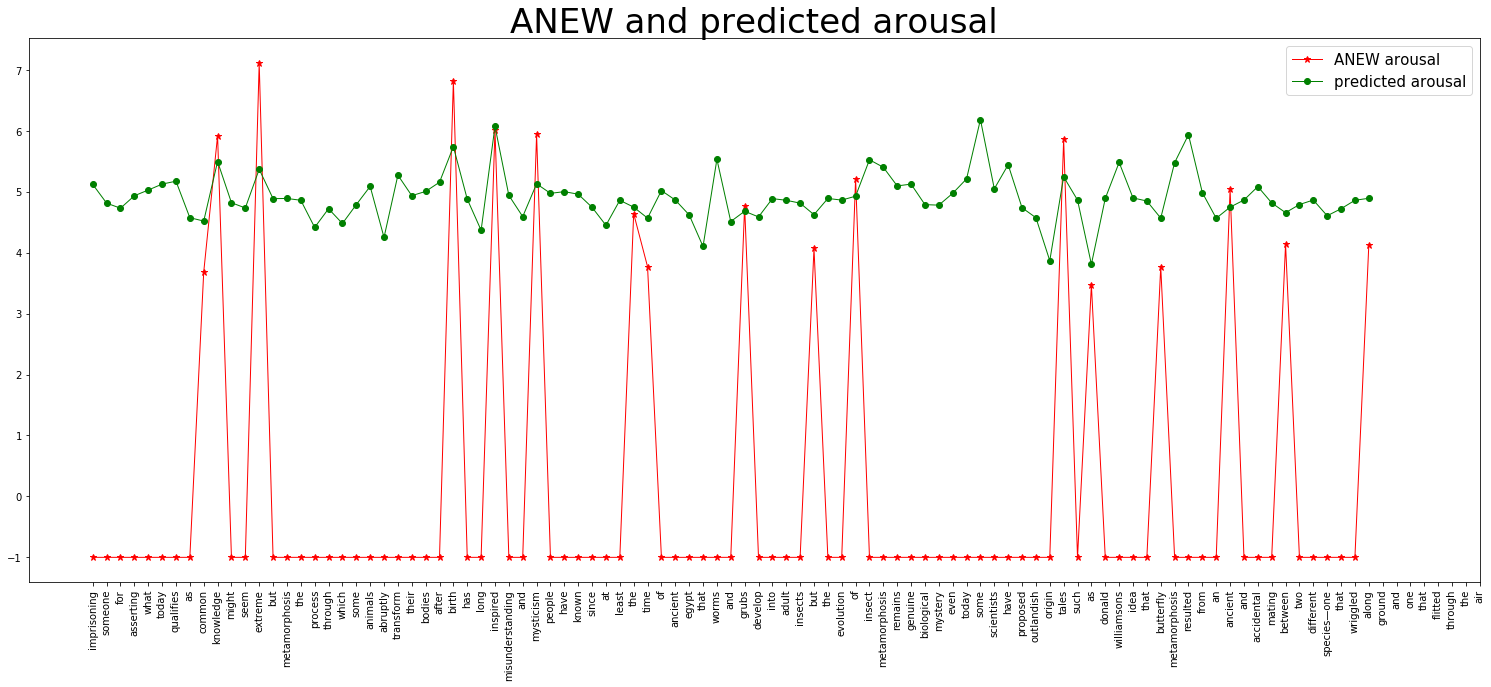

In [47]:
_, ax = plt.subplots()

ax.plot(ratings_anew[:,1], label='ANEW arousal', lw=1, markersize = 7, marker = '*', color='red')
ax.plot(ratings_predicted[:,1], label='predicted arousal', lw=1, markersize = 6, marker = 'o', color='green')

ax.set_xticklabels(text_words)
ax.xaxis.set_ticks(np.arange(0, len(text_words), 1))
plt.xticks(rotation=90)
plt.title("ANEW and predicted arousal", fontsize=34)
plt.legend(fontsize=15)
plt.show()

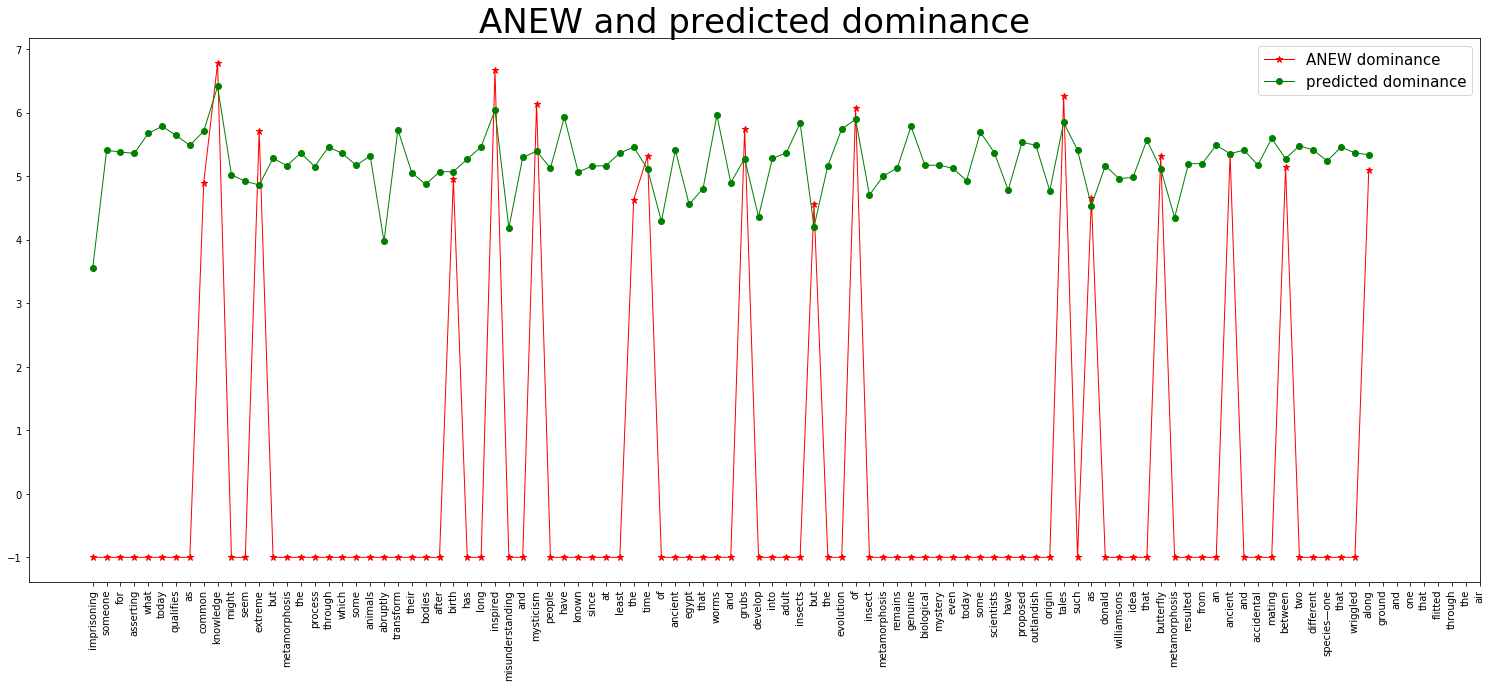

In [49]:
_, ax = plt.subplots()

ax.plot(ratings_anew[:,2], label='ANEW dominance', lw=1, markersize = 7, marker = '*', color='red')
ax.plot(ratings_predicted[:,2], label='predicted dominance', lw=1, markersize = 6, marker = 'o', color='green')

ax.set_xticklabels(text_words)
ax.xaxis.set_ticks(np.arange(0, len(text_words), 1))
plt.xticks(rotation=90)
plt.title("ANEW and predicted dominance", fontsize=34)
plt.legend(fontsize=15)
plt.show()

## Limitations
- In the above examples, the a word's context is not taken into account (akin to a unigram model). Thus predicted sentiment (word or sentence) will completely miss complex meanings that people use in natural settings, e.g. sarcasm.
- Valence and arousal are not really independent of each other. If the valence of a stimulus (here, word) is known, the arousal can be often predicted to a certain degree. This issue is explored in depth (for visual stimuli) in [3]

## References

[1] http://www.csea.phhp.ufl.edu/media/anewmessage.html <br>

[2] Bradley, M. M., & Lang, P. J. (1999). Affective norms for English words (ANEW): Instruction manual and affective ratings (Vol. 30, No. 1, pp. 25-36). Technical report C-1, the center for research in psychophysiology, University of Florida. <br>

[3] Kuppens, P., Tuerlinckx, F., Russell, J. A., & Barrett, L. F. (2013). The relation between valence and arousal in subjective experience. Psychological Bulletin, 139(4), 917. <br>